In [1]:
!git clone https://github.com/Ignas12345/Magistras_pagalbines_funkcijos.git
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

from Magistras_pagalbines_funkcijos.pagalbines_funkcijos import *

Cloning into 'Magistras_pagalbines_funkcijos'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 84 (delta 28), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 35.46 KiB | 1.87 MiB/s, done.
Resolving deltas: 100% (28/28), done.


Čia bandoma atkartoti TCGA tyrimo 4 paveiksliuką - daug kas gaunasi panašiai, tik su Teratoma skirtingai (p-value kitokie ir gal reiktų pakeisti kodą, taip, kad neišfiltruojam silpniau išreikštų miRNR, bet juos kažkaip paryškinam arba tiesiog paliekam jeigu vidurkis bent vienoje iš grupių siekia 50 RPM).

In [2]:
def collapse_columns_by_string(df, string_len=12, suffix_or_prefix = 'suffix'):
    """
    Collapses columns in a DataFrame based on matching string of column names (last `string_len` characters).

    Args:
        df (pd.DataFrame): DataFrame with features as columns and samples as rows.
        string_len (int): Number of characters from the end of the feature name to match on.

    Returns:
        pd.DataFrame: DataFrame with collapsed columns (features), summed across matching key_strings.
    """
    import pandas as pd

    # Extract string from each column name
    if suffix_or_prefix == 'suffix':
      key_strings = df.columns.to_series().str[-string_len:]
    elif suffix_or_prefix == 'prefix':
      key_strings = df.columns.to_series().str[:string_len]

    # Group column names by their string
    grouped = {}
    for string in key_strings.unique():
        cols = key_strings[key_strings == string].index.tolist()
        grouped[string] = cols

    # Build new DataFrame with collapsed columns
    collapsed_data = {}
    for string, cols in grouped.items():
        # Sum across the columns that match this string
        collapsed_data[cols[0]] = df[cols].sum(axis=1)

    # Construct new DataFrame
    collapsed_df = pd.DataFrame(collapsed_data)

    return collapsed_df.copy()


In [3]:
folder_1 = 'https://raw.githubusercontent.com/Ignas12345/Magistras_knygutes_ir_duomenys/refs/heads/main/duomenys/TCGA_TGCT/'
url_miRNR_normalized_isoforms = folder_1 + 'isoform_reads_per_million_RNA_mapped.csv'
mirna_normalized_isoforms_df, mirna_features = format_data_frame(url_miRNR_normalized_isoforms,chars_slice=slice(15), has_features=True, sample_start_index=1, feature_id_index=0)

url_mdata_1 = folder_1 + 'TCGA_TGCT_mdata_1.csv'
mdata_1 = pd.read_csv(url_mdata_1, sep = ';', index_col=0)
url_mdata_2 = folder_1 + 'TCGA_TGCT_mdata_2.csv'
mdata_2 = pd.read_csv(url_mdata_2, sep = '|', index_col = 0)

reading df from url: https://raw.githubusercontent.com/Ignas12345/Magistras_knygutes_ir_duomenys/refs/heads/main/duomenys/TCGA_TGCT/isoform_reads_per_million_RNA_mapped.csv
df transposed
sample names truncated using: slice(None, 15, None)
final shape of df: (156, 3689)

returning: (df, feature_ids)


In [4]:
samples = mdata_2.index.intersection(mirna_normalized_isoforms_df.index)
mdata_2 = mdata_2.loc[samples].copy()
mirna_normalized_isoforms_df = mirna_normalized_isoforms_df.loc[samples].copy()
diagnoses = mdata_2['multiclass updated 20160629']

In [ ]:
mirna_normalized_isoforms_df.columns.to_list()[1000:]

['hsa-mir-3171, unannotated',
 'hsa-mir-3173, mature,MIMAT0015048',
 'hsa-mir-3173, mature,MIMAT0019214',
 'hsa-mir-3173, precursor',
 'hsa-mir-3174, mature,MIMAT0015051',
 'hsa-mir-3174, precursor',
 'hsa-mir-3174, unannotated',
 'hsa-mir-3175, mature,MIMAT0015052',
 'hsa-mir-3175, unannotated',
 'hsa-mir-3176, mature,MIMAT0015053',
 'hsa-mir-3176, unannotated',
 'hsa-mir-3177, mature,MIMAT0015054',
 'hsa-mir-3177, mature,MIMAT0019215',
 'hsa-mir-3177, precursor',
 'hsa-mir-3178, mature,MIMAT0015055',
 'hsa-mir-3178, stemloop',
 'hsa-mir-3178, unannotated',
 'hsa-mir-3180-1, precursor',
 'hsa-mir-3180-2, precursor',
 'hsa-mir-3180-3, precursor',
 'hsa-mir-3180-3, stemloop',
 'hsa-mir-3180-4, precursor',
 'hsa-mir-3180-4, unannotated',
 'hsa-mir-3180-5, mature,MIMAT0018178',
 'hsa-mir-3180-5, precursor',
 'hsa-mir-3181, mature,MIMAT0015061',
 'hsa-mir-3181, unannotated',
 'hsa-mir-3182, mature,MIMAT0015062',
 'hsa-mir-3183, mature,MIMAT0015063',
 'hsa-mir-3183, unannotated',
 'hsa-mir-

In [5]:
df_to_use = mirna_normalized_isoforms_df.copy()
print(len(df_to_use.columns))
df_to_use = df_to_use.loc[:,~df_to_use.columns.str.endswith(('unannotated', 'precursor', 'stemloop'))].copy()
print(len(df_to_use.columns))
df_to_use = collapse_columns_by_string(df_to_use, suffix_or_prefix='suffix')
print(len(df_to_use.columns))

#features_to_keep = [feature for feature in df_to_use.columns if df_to_use[feature].mean() >= 45]
#df_to_use = df_to_use[features_to_keep]
#print(len(df_to_use.columns))

3689
2324
2191


In [ ]:
df_to_use = collapse_columns_by_string(mirna_normalized_isoforms_df)
print(len(df_to_use.columns))
df_to_use = df_to_use.loc[:,~df_to_use.columns.str.endswith(('unannotated', 'precursor', 'stemloop'))].copy()
print(len(df_to_use.columns))
df_to_use = df_to_use.copy()
#features_to_keep = [feature for feature in df_to_use.columns if df_to_use[feature].mean() >= 45]
#df_to_use = df_to_use[features_to_keep]
#print(len(df_to_use.columns))


2335
2191
296


In [6]:
labels = diagnoses.to_dict()
label_sample_dict = invert_label_dict(labels, original_keys = 'samples')

In [7]:
set(labels.values())

{'embryonal',
 'embryonal dominant',
 'immature teratoma dominant',
 'mature teratoma',
 'mature teratoma dominant',
 'non-seminoma- mixed (no dominant component)',
 'seminoma',
 'yolk sac',
 'yolk sac dominant'}

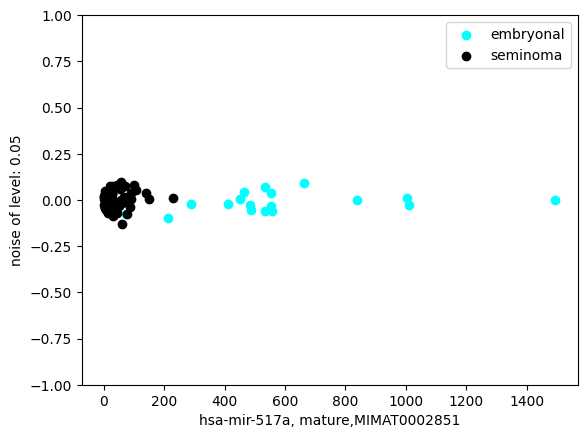

In [ ]:
plot_single_feature(df_to_use, 'hsa-mir-517a, mature,MIMAT0002851', samples_to_use = group1_samples + group2_samples, sample_label_dict= labels)

In [8]:
# Function for differential expression and plotting
def plot_differential_miRNAs(df_to_use, group1_samples, group2_samples, n_features_to_plot = 17, group_names = ('group a', ' group b'), label_dict = None):


    group1_name = group_names[0]
    group2_name = group_names[1]
    print('number of samples in ' + group1_name + ': ' + str(len(group1_samples)))
    print('number of samples in ' + group2_name + ': ' + str(len(group2_samples)))
    # Extract expression data for the two groups
    data1 = df_to_use.loc[group1_samples].copy()
    data2 = df_to_use.loc[group2_samples].copy()

    threshold_to_keep = 45
    #leave only the features that reach 50 (45 for safety) RPM in any of the classes
    features_to_keep_1 = [feature for feature in data1.columns if data1[feature].mean() >= 45]
    features_to_keep_2 = [feature for feature in data2.columns if data2[feature].mean() >= 45]
    features_to_keep = list(set(features_to_keep_1).union(set(features_to_keep_2)))
    print('number of features expressed above ' + str(threshold_to_keep)+' in ' + group1_name + ': ' + str(len(features_to_keep_1)))
    print('number of features expressed above ' + str(threshold_to_keep)+' in ' + group2_name + ': ' + str(len(features_to_keep_2)))
    print('number of features in kept across both groups: ' + str(len(features_to_keep)))
    data1 = data1[features_to_keep]
    data2 = data2[features_to_keep]
    df_to_use = df_to_use[features_to_keep].copy()

    # Perform unpaired t-test
    p_vals = []
    fold_changes = []
    for miRNA in df_to_use.columns:
        vals1 = data1[miRNA].values.astype(float)
        vals2 = data2[miRNA].values.astype(float)
        t_stat, p = ttest_ind(vals1, vals2, equal_var=False)
        p_vals.append(p)

        fc = np.median(vals1 + 1) / np.median(vals2 + 1)
        if fc < 1:
            fc =  - 1 / fc
        # Median-based fold change
        #fold_changes.append(np.log2(fc))  # log2 FC
        fold_changes.append(fc)

    # FDR correction
    reject, p_adj = fdrcorrection(p_vals, alpha=0.05)
    results = pd.DataFrame({
        'miRNA': df_to_use.columns,
        'Fold Change': fold_changes,
        'pval': p_vals,
        'fdr': p_adj,
        'significant': reject
    })

    # Keep only significant ones
    sig_results = results[results['significant']]

    # Top 15 up and down
    top_up = sig_results.sort_values("Fold Change", ascending=False).head(n_features_to_plot)
    top_down = sig_results.sort_values("Fold Change").head(n_features_to_plot)[::-1]
    top_miRNAs = pd.concat([top_up, top_down])

    # Barplot of log2 fold changes
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_miRNAs,
        y="miRNA", x="Fold Change",
        palette=["#E41A1C" if x > 0 else "#377EB8" for x in top_miRNAs["Fold Change"]]
    )
    plt.axvline(0, color="black", linestyle="--")
    plt.title(f"Top Differentially Abundant miRNAs (Fold Change)\n{group1_name} vs {group2_name}")
    plt.tight_layout()
    plt.show()

    # Boxplots for top miRNAs
    expr_top = df_to_use.loc[group1_samples + group2_samples, top_miRNAs["miRNA"]].copy()
    #expr_top["sample_id"] = expr_top.index
    #add a log10 transformation:
    expr_top_log10 = pd.DataFrame(index=expr_top.index)
    for col in expr_top.columns:
      data = expr_top[col].to_numpy()
      expr_top_log10[col] = np.log10(data.astype(np.float64) + 1)

    # Melt long format
    expr_top["sample_id"] = expr_top.index
    expr_top_log10["sample_id"] = expr_top.index
    melted_data = expr_top_log10.melt(id_vars="sample_id", var_name="miRNA", value_name="RPM")

    # Add group info using sample_id
    #label_df = pd.DataFrame.from_dict(label_dict, orient='index', columns=['group'])
    #melted_data["group"] = label_df.loc[melted_data["sample_id"], 'group'].values
    if label_dict is None:
      melted_data["group"] = diagnoses.loc[melted_data["sample_id"]].values
    else:
      label_df = pd.DataFrame.from_dict(label_dict, orient='index')
      melted_data["group"] = label_df.loc[melted_data["sample_id"]][0].values
    #melted_data["group"] = diagnoses.loc[melted_data.index].values

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted_data, x="miRNA", y="RPM", hue="group", showfliers=False)
    plt.ylabel("log10(RPM+1)")
    plt.xticks(rotation=90)
    plt.title(f"RPM Distribution of Top miRNAs\n{group1_name} vs {group2_name}")
    plt.tight_layout()
    plt.show()

    return results

In [9]:
two_class_diagnoses = mdata_2['two-class updated 20160629']

In [10]:
experiment_labels_df = pd.DataFrame(index = samples)
experiment_results_df = pd.DataFrame(index = df_to_use.columns.to_list())

In [11]:
experiment_results_df

""
"hsa-let-7a-1, mature,MIMAT0000062"
"hsa-let-7a-1, mature,MIMAT0004481"
"hsa-let-7a-2, mature,MIMAT0010195"
"hsa-let-7b, mature,MIMAT0000063"
"hsa-let-7b, mature,MIMAT0004482"
...
"hsa-mir-98, mature,MIMAT0022842"
"hsa-mir-99a, mature,MIMAT0000097"
"hsa-mir-99a, mature,MIMAT0004511"
"hsa-mir-99b, mature,MIMAT0000689"


In [12]:
experiment_labels_df

""
TCGA-2G-AAEW-01
TCGA-2G-AAEX-01
TCGA-2G-AAF1-01
TCGA-2G-AAF4-01
TCGA-2G-AAF6-01
...
TCGA-ZM-AA0D-01
TCGA-ZM-AA0E-01
TCGA-ZM-AA0F-01
TCGA-ZM-AA0H-01


non-seminoma vs seminoma

number of samples in non-seminoma: 61
number of samples in seminoma: 72
number of features expressed above 45 in non-seminoma: 316
number of features expressed above 45 in seminoma: 241
number of features in kept across both groups: 331


<ipython-input-8-f11d24ba1231>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


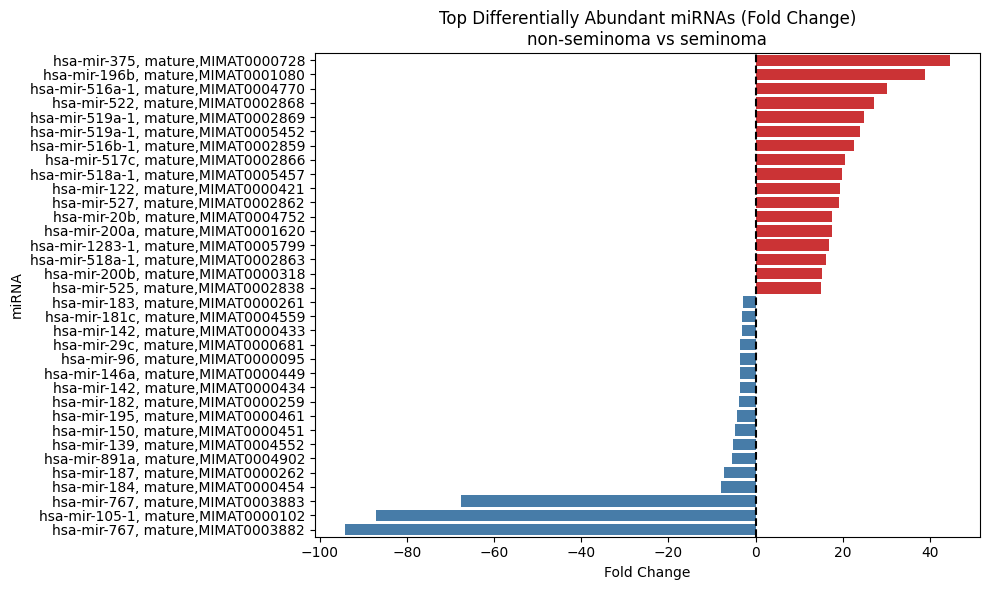

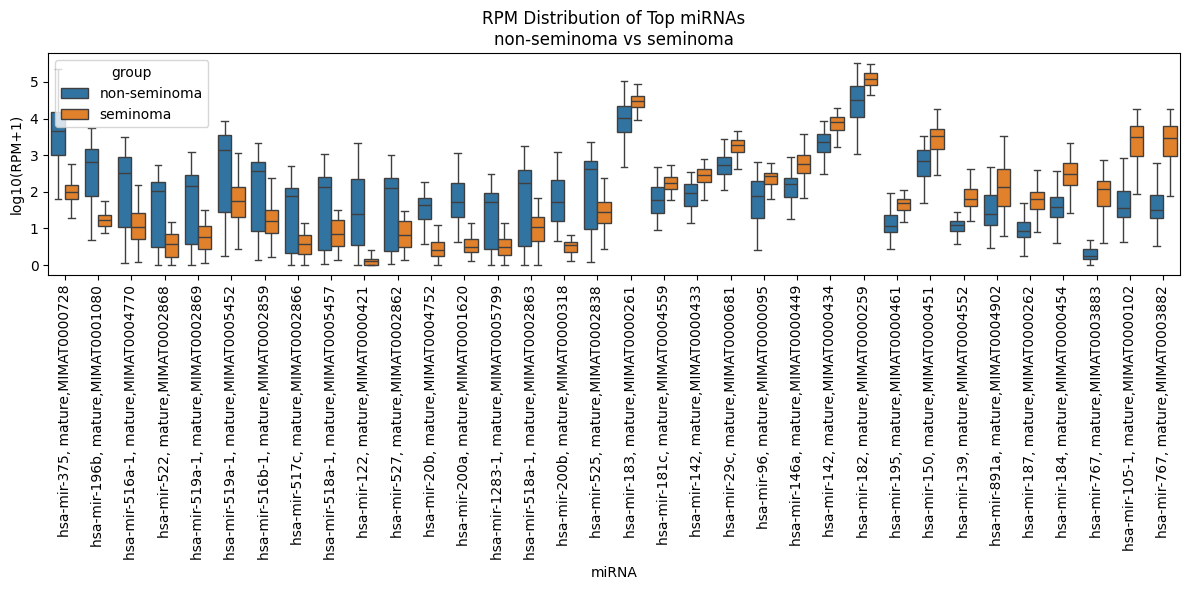

In [13]:
labels_binary_seminoma = two_class_diagnoses.to_dict()
for sample in labels_binary_seminoma.keys():
  if mdata_2['Seminoma % '][sample] < 100:
    labels_binary_seminoma[sample] = 'mixed sample (unused)'

label_sample_dict_binary = invert_label_dict(labels_binary_seminoma, original_keys = 'samples')

group1_samples = prepare_sample_list(["non-seminoma"], label_sample_dict=label_sample_dict_binary)
group2_samples = prepare_sample_list(["seminoma"], label_sample_dict=label_sample_dict_binary)
group_names=["non-seminoma", "seminoma"]
results_seminoma_non_seminoma = plot_differential_miRNAs(df_to_use, group1_samples, group2_samples, group_names=group_names, label_dict = labels_binary_seminoma)

In [14]:
def reformat_results(results_df, experiment_name):
  results_df = results_df.copy()
  results_df = results_df.set_index('miRNA')
  for column in results_df.columns:
    results_df.rename(columns={column: experiment_name + ' ' + column}, inplace=True)
  return results_df

In [15]:
results_seminoma_non_seminoma = reformat_results(results_seminoma_non_seminoma, 'seminoma vs non-seminoma')

In [16]:
results_seminoma_non_seminoma

,seminoma vs non-seminoma Fold Change,seminoma vs non-seminoma pval,seminoma vs non-seminoma fdr,seminoma vs non-seminoma significant
miRNA,,,,
"hsa-mir-134, mature,MIMAT0000447",1.333265,5.453828e-02,6.943142e-02,False
"hsa-mir-371a, mature,MIMAT0004687",-1.498982,9.307836e-03,1.294493e-02,True
"hsa-mir-361, mature,MIMAT0004682",-1.616594,1.033384e-13,6.128715e-12,True
"hsa-mir-136, mature,MIMAT0004606",1.249956,6.820754e-04,1.075081e-03,True
"hsa-mir-221, mature,MIMAT0000278",1.384951,1.826498e-04,3.148806e-04,True
...,...,...,...,...
"hsa-mir-205, mature,MIMAT0000266",12.972311,5.401390e-08,2.554086e-07,True
"hsa-mir-342, mature,MIMAT0000753",-1.824930,7.251222e-11,9.907990e-10,True
"hsa-mir-128-1, mature,MIMAT0000424",-1.586504,4.673826e-04,7.583512e-04,True


In [16]:
experiment_labels_df['seminoma vs non-seminoma'] = labels_binary_seminoma
experiment_results_df = pd.concat([experiment_results_df, results_seminoma_non_seminoma], axis=1)

In [17]:
experiment_labels_df[0:]

,seminoma vs non-seminoma
TCGA-2G-AAEW-01,seminoma
TCGA-2G-AAEX-01,seminoma
TCGA-2G-AAF1-01,seminoma
TCGA-2G-AAF4-01,seminoma
TCGA-2G-AAF6-01,seminoma
...,...
TCGA-ZM-AA0D-01,seminoma
TCGA-ZM-AA0E-01,seminoma
TCGA-ZM-AA0F-01,seminoma
TCGA-ZM-AA0H-01,seminoma


In [19]:
experiment_results_df

,seminoma vs non-seminoma Fold Change,seminoma vs non-seminoma pval,seminoma vs non-seminoma fdr,seminoma vs non-seminoma significant
"hsa-let-7a-1, mature,MIMAT0000062",1.016323,0.147996,0.176211,False
"hsa-let-7a-1, mature,MIMAT0004481",NaN,NaN,NaN,NaN
"hsa-let-7a-2, mature,MIMAT0010195",NaN,NaN,NaN,NaN
"hsa-let-7b, mature,MIMAT0000063",-1.195322,0.869566,0.880203,False
"hsa-let-7b, mature,MIMAT0004482",NaN,NaN,NaN,NaN
...,...,...,...,...
"hsa-mir-98, mature,MIMAT0022842",NaN,NaN,NaN,NaN
"hsa-mir-99a, mature,MIMAT0000097",2.974743,0.000019,0.000039,True
"hsa-mir-99a, mature,MIMAT0004511",NaN,NaN,NaN,NaN
"hsa-mir-99b, mature,MIMAT0000689",1.416475,0.000016,0.000034,True


embryonal vs seminoma

number of samples in embryonal: 18
number of samples in seminoma: 72
number of features expressed above 45 in embryonal: 284
number of features expressed above 45 in seminoma: 241
number of features in kept across both groups: 302


<ipython-input-8-f11d24ba1231>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


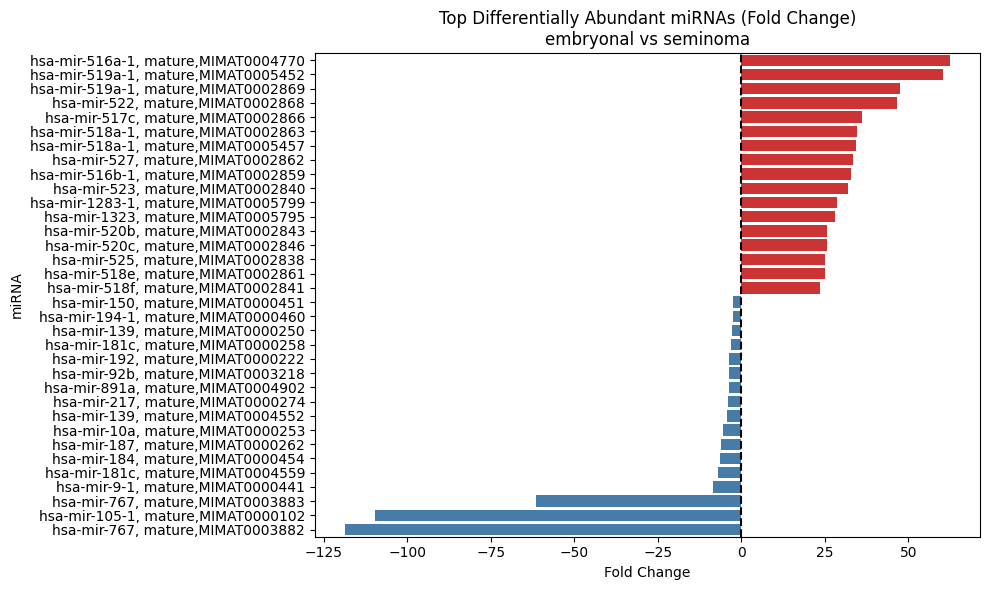

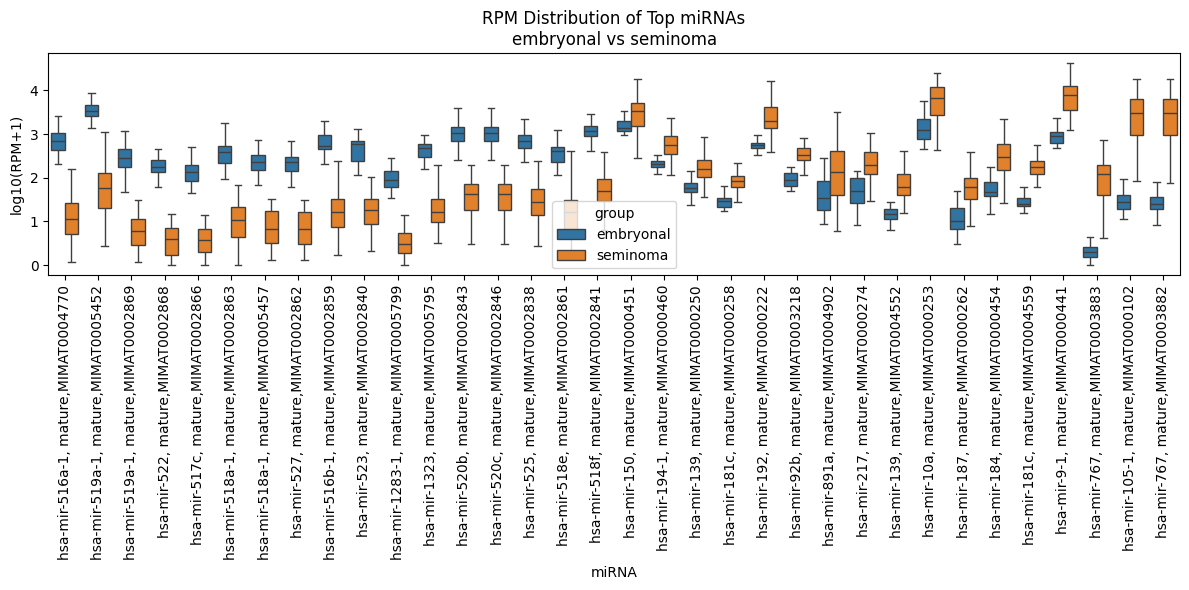

In [18]:
group1_samples = prepare_sample_list(["embryonal"], label_sample_dict=label_sample_dict)
group2_samples = prepare_sample_list(["seminoma"], label_sample_dict=label_sample_dict)
labels_embryonal_seminoma = diagnoses.to_dict()
for sample in labels_embryonal_seminoma.keys():
  if labels_embryonal_seminoma[sample] != "embryonal" and labels_embryonal_seminoma[sample] != "seminoma":
    labels_embryonal_seminoma[sample] = 'non_embryonal non_seminoma (unused)'

group_names=["embryonal", "seminoma"]
results_embryonal_seminoma = plot_differential_miRNAs(df_to_use, group1_samples, group2_samples, group_names=group_names, label_dict = labels_embryonal_seminoma)

In [19]:
'''
experiment_labels_df['seminoma vs non-seminoma'] = labels_binary_seminoma
experiment_results_df = pd.concat([experiment_results_df, results_seminoma_non_seminoma], axis=1)
'''
results_embryonal_seminoma = reformat_results(results_embryonal_seminoma, 'embryonal vs seminoma')
experiment_labels_df['embryonal vs seminoma'] = labels_embryonal_seminoma
experiment_results_df = pd.concat([experiment_results_df, results_embryonal_seminoma], axis=1)

In [20]:
experiment_results_df

,seminoma vs non-seminoma Fold Change,seminoma vs non-seminoma pval,seminoma vs non-seminoma fdr,seminoma vs non-seminoma significant,embryonal vs seminoma Fold Change,embryonal vs seminoma pval,embryonal vs seminoma fdr,embryonal vs seminoma significant
"hsa-let-7a-1, mature,MIMAT0000062",1.016323,0.147996,0.176211,False,1.251202,0.031470,0.053393,False
"hsa-let-7a-1, mature,MIMAT0004481",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7a-2, mature,MIMAT0010195",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7b, mature,MIMAT0000063",-1.195322,0.869566,0.880203,False,1.235743,0.121741,0.166361,False
"hsa-let-7b, mature,MIMAT0004482",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
"hsa-mir-98, mature,MIMAT0022842",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99a, mature,MIMAT0000097",2.974743,0.000019,0.000039,True,1.434068,0.107384,0.148930,False
"hsa-mir-99a, mature,MIMAT0004511",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99b, mature,MIMAT0000689",1.416475,0.000016,0.000034,True,-1.254802,0.006615,0.013408,True


In [ ]:
diagnoses.value_counts()

,count
multiclass updated 20160629,
seminoma,72
embryonal,18
mature teratoma dominant,10
embryonal dominant,9
non-seminoma- mixed (no dominant component),9
yolk sac dominant,8
yolk sac,5
mature teratoma,3
immature teratoma dominant,3


embryonal vs non-embryonal ir non_seminoma

number of samples in embryonal: 18
number of samples in non-embryonal non-seminoma: 19
number of features expressed above 45 in embryonal: 284
number of features expressed above 45 in non-embryonal non-seminoma: 304
number of features in kept across both groups: 346


<ipython-input-8-f11d24ba1231>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


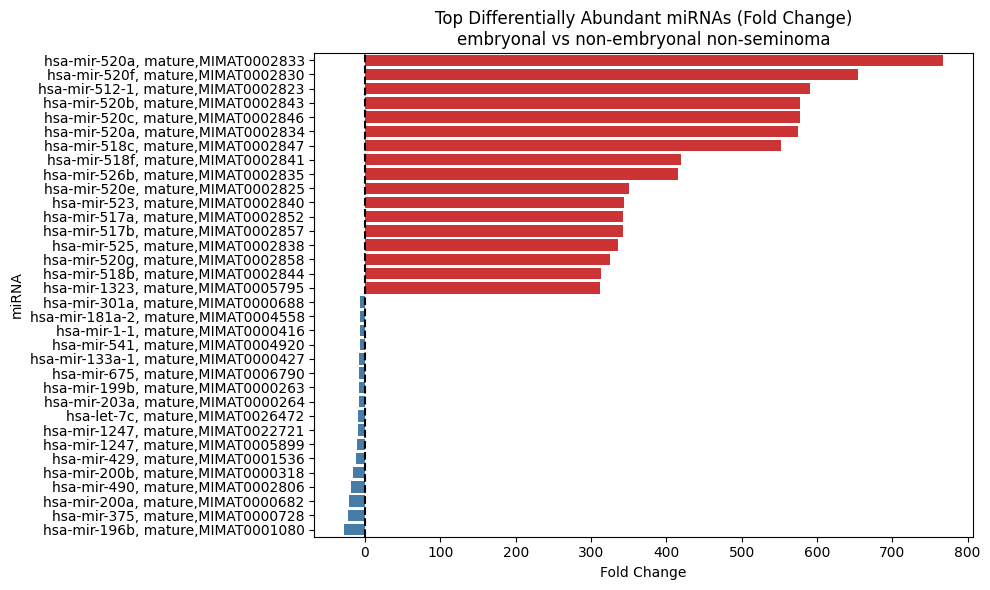

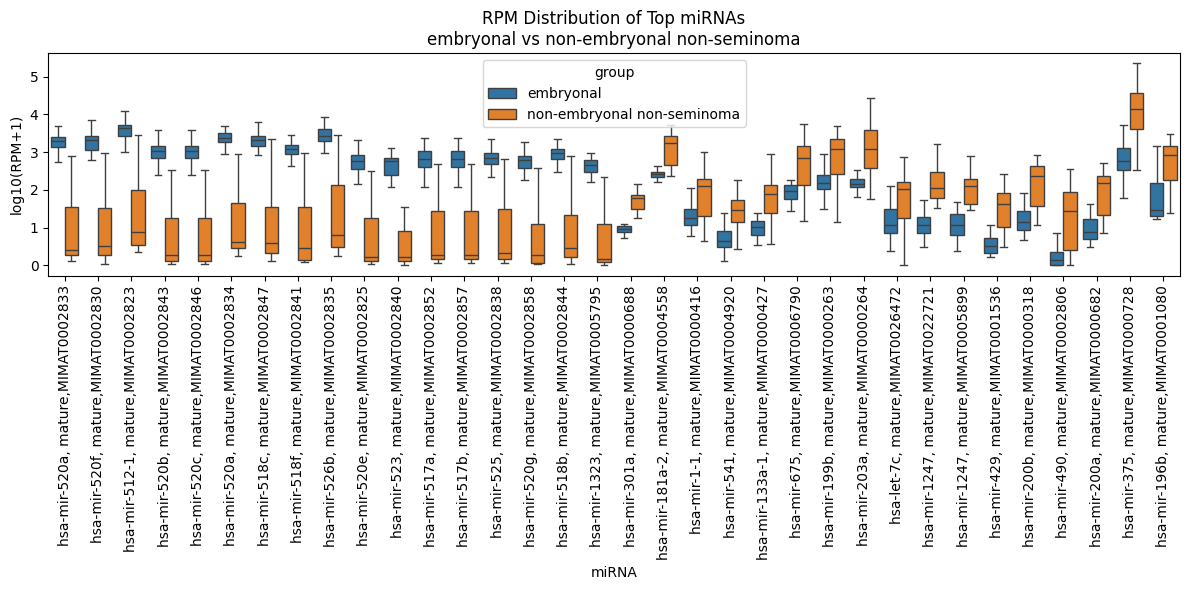

In [24]:
labels_non_seminoma_non_embryonal = diagnoses.to_dict()
for sample in labels_non_seminoma_non_embryonal.keys():
  if pd.isna(mdata_2['Seminoma % '][sample]) and  pd.isna(mdata_2['Embryonal carcinoma %'][sample]):
    labels_non_seminoma_non_embryonal[sample] = 'non-embryonal non-seminoma'
  elif labels_non_seminoma_non_embryonal[sample] != "embryonal" :
    labels_non_seminoma_non_embryonal[sample] = 'unused'

label_sample_dict = invert_label_dict(labels_non_seminoma_non_embryonal, original_keys = 'samples')

group1_samples = prepare_sample_list(["embryonal"], label_sample_dict=label_sample_dict)
group2_samples = prepare_sample_list(["non-embryonal non-seminoma"], label_sample_dict=label_sample_dict)
group_names=["embryonal", "non-embryonal non-seminoma"]
results_embryonal_non_embryonal = plot_differential_miRNAs(df_to_use, group1_samples, group2_samples, group_names=group_names, label_dict = labels_non_seminoma_non_embryonal)

In [25]:
'''
results_embryonal_non_embryonal = reformat_results(results_embryonal_non_embryonal, 'embryonal vs non_embryonal_non_seminoma')
experiment_labels_df['embryonal vs non_embryonal_non_seminoma'] = labels_results_embryonal_non_embryonal
experiment_results_df = pd.concat([experiment_results_df, results_embryonal_non_embryonal], axis=1)
'''

results_embryonal_non_embryonal = reformat_results(results_embryonal_non_embryonal, 'embryonal vs non_embryonal_non_seminoma')
experiment_labels_df['embryonal vs non_embryonal_non_seminoma'] = labels_non_seminoma_non_embryonal
experiment_results_df = pd.concat([experiment_results_df, results_embryonal_non_embryonal], axis=1)

In [26]:
experiment_results_df

,seminoma vs non-seminoma Fold Change,seminoma vs non-seminoma pval,seminoma vs non-seminoma fdr,seminoma vs non-seminoma significant,embryonal vs seminoma Fold Change,embryonal vs seminoma pval,embryonal vs seminoma fdr,embryonal vs seminoma significant,embryonal vs non_embryonal_non_seminoma Fold Change,embryonal vs non_embryonal_non_seminoma pval,embryonal vs non_embryonal_non_seminoma fdr,embryonal vs non_embryonal_non_seminoma significant
"hsa-let-7a-1, mature,MIMAT0000062",1.016323,0.147996,0.176211,False,1.251202,0.031470,0.053393,False,1.179961,0.328466,0.386562,False
"hsa-let-7a-1, mature,MIMAT0004481",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7a-2, mature,MIMAT0010195",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7b, mature,MIMAT0000063",-1.195322,0.869566,0.880203,False,1.235743,0.121741,0.166361,False,1.540435,0.113442,0.149813,False
"hsa-let-7b, mature,MIMAT0004482",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
"hsa-mir-98, mature,MIMAT0022842",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99a, mature,MIMAT0000097",2.974743,0.000019,0.000039,True,1.434068,0.107384,0.148930,False,-4.549685,0.004814,0.010787,True
"hsa-mir-99a, mature,MIMAT0004511",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99b, mature,MIMAT0000689",1.416475,0.000016,0.000034,True,-1.254802,0.006615,0.013408,True,-3.283565,0.000003,0.000097,True


In [28]:
experiment_labels_df[:15]

,seminoma vs non-seminoma,embryonal vs seminoma,embryonal vs non_embryonal_non_seminoma
TCGA-2G-AAEW-01,seminoma,seminoma,unused
TCGA-2G-AAEX-01,seminoma,seminoma,unused
TCGA-2G-AAF1-01,seminoma,seminoma,unused
TCGA-2G-AAF4-01,seminoma,seminoma,unused
TCGA-2G-AAF6-01,seminoma,seminoma,unused
TCGA-2G-AAF8-01,seminoma,seminoma,unused
TCGA-2G-AAFG-01,seminoma,seminoma,unused
TCGA-2G-AAFH-01,seminoma,seminoma,unused
TCGA-2G-AAFI-01,non-seminoma,non_embryonal non_seminoma (unused),unused
TCGA-2G-AAFJ-01,non-seminoma,non_embryonal non_seminoma (unused),non-embryonal non-seminoma


Teratoma vs non-teratoma

number of samples in teratoma: 6
number of samples in non-teratoma: 107
number of features expressed above 45 in teratoma: 276
number of features expressed above 45 in non-teratoma: 279
number of features in kept across both groups: 336


<ipython-input-8-f11d24ba1231>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


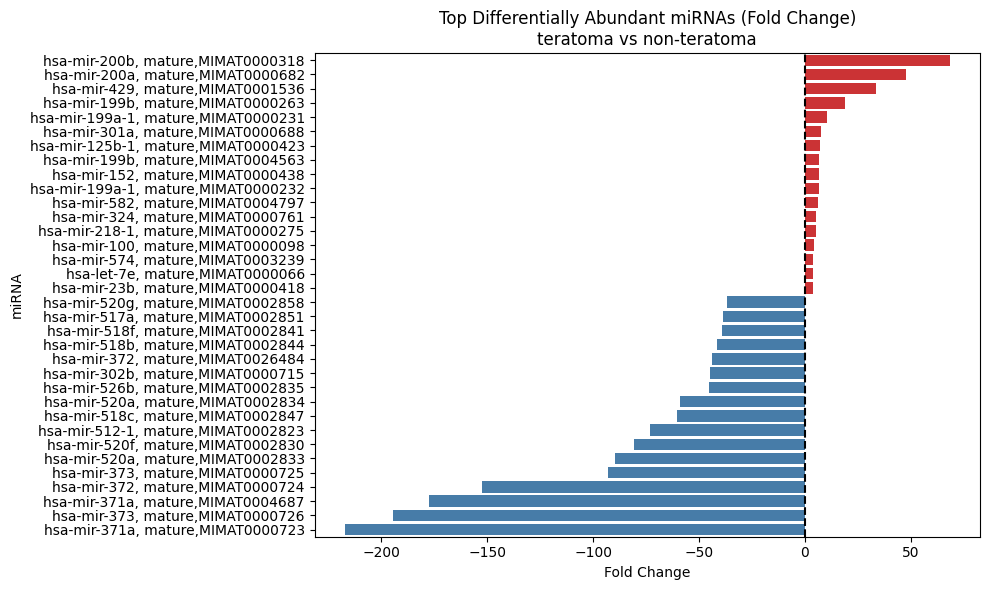

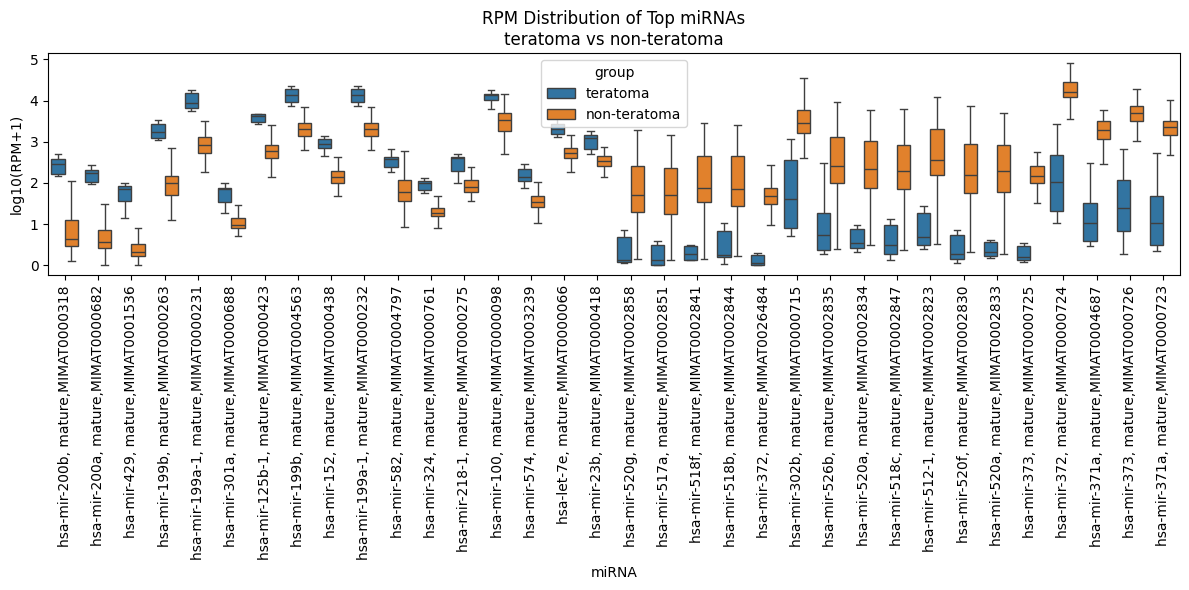

In [29]:
labels_teratoma = diagnoses.to_dict()
for sample in labels_teratoma.keys():
  if pd.isna(mdata_2['Mature %'][sample]) and  pd.isna(mdata_2['Immature %'][sample]):
    labels_teratoma[sample] = 'non-teratoma'
  elif (mdata_2['Mature %'][sample] == 100 or mdata_2['Immature %'][sample] == 100) or (mdata_2['Mature %'][sample] + mdata_2['Immature %'][sample]) == 100:
    labels_teratoma[sample] = 'teratoma'
  else:
    labels_teratoma[sample] = 'unused'

label_sample_dict = invert_label_dict(labels_teratoma, original_keys = 'samples')

group1_samples = prepare_sample_list(["teratoma"], label_sample_dict=label_sample_dict)
group2_samples = prepare_sample_list(["non-teratoma"], label_sample_dict=label_sample_dict)
group_names=["teratoma", "non-teratoma"]
results_teratoma = plot_differential_miRNAs(df_to_use, group1_samples, group2_samples, group_names=group_names, label_dict = labels_teratoma)

In [30]:
results_teratoma = reformat_results(results_teratoma, 'teratoma vs non-teratoma')
experiment_labels_df['teratoma vs non-teratoma'] = labels_teratoma
experiment_results_df = pd.concat([experiment_results_df, results_teratoma], axis=1)

In [32]:
experiment_labels_df

,seminoma vs non-seminoma,embryonal vs seminoma,embryonal vs non_embryonal_non_seminoma,teratoma vs non-teratoma
TCGA-2G-AAEW-01,seminoma,seminoma,unused,non-teratoma
TCGA-2G-AAEX-01,seminoma,seminoma,unused,non-teratoma
TCGA-2G-AAF1-01,seminoma,seminoma,unused,non-teratoma
TCGA-2G-AAF4-01,seminoma,seminoma,unused,non-teratoma
TCGA-2G-AAF6-01,seminoma,seminoma,unused,non-teratoma
...,...,...,...,...
TCGA-ZM-AA0D-01,seminoma,seminoma,unused,non-teratoma
TCGA-ZM-AA0E-01,seminoma,seminoma,unused,non-teratoma
TCGA-ZM-AA0F-01,seminoma,seminoma,unused,non-teratoma
TCGA-ZM-AA0H-01,seminoma,seminoma,unused,non-teratoma


Čia kažkas netaip (tos p-values nėra kaip TCGA tyrime, todėl nepriskiriami kai kurie miRNR prie gerai diferencijuojančių - pvz., tas hsa-mir-375) Reiks pasigilinti, ką daryti, kad tai pakeisti. ir pasigilinti į tai kaip tas p-value yra skaičiuojamas.

In [34]:
results_teratoma.sort_values('teratoma vs non-teratoma Fold Change')[::-1][:15]

,teratoma vs non-teratoma Fold Change,teratoma vs non-teratoma pval,teratoma vs non-teratoma fdr,teratoma vs non-teratoma significant
miRNA,,,,
"hsa-mir-375, mature,MIMAT0000728",88.793831,0.785303,0.814388,False
"hsa-mir-215, mature,MIMAT0000272",80.991298,0.103181,0.166677,False
"hsa-mir-200b, mature,MIMAT0000318",68.336424,0.018260,0.049062,True
"hsa-mir-490, mature,MIMAT0002806",62.270282,0.075971,0.143407,False
"hsa-mir-200a, mature,MIMAT0000682",47.860000,0.014319,0.040429,True
"hsa-mir-196b, mature,MIMAT0001080",46.542996,0.034238,0.078794,False
"hsa-mir-133a-1, mature,MIMAT0000427",40.368102,0.079550,0.144479,False
"hsa-mir-1-1, mature,MIMAT0000416",36.176628,0.078975,0.144479,False
"hsa-mir-429, mature,MIMAT0001536",33.319042,0.010693,0.032664,True


In [ ]:
def plot_single_feature(df, feature, samples_to_use:list|None = None, noise_level = 0.05, sample_ordering:list|None = None,
                                  sample_label_dict : dict = None, label_color_dict = None, samples_to_higlight: list|None = None,
                                  xlim = None, ylim = None, show_legend = True, title = None, slice_for_samples:slice = None, use_numbers:bool = None, save_plot = False, random_seed = 42):
  #paima df, kuriu rows yra observazijos ir padaro vieno bruozo plot'a su trupuciu triuksmo.
  #label_dict turėtų turėti sample_ids kaip raktus ir etiketes kaip values
  #slice_for_samples, use_numbers argumentai yra naudojami kitame funckijos variante - ten kur su tekstu plotinna - cia jie nereikalingi
  print('a')
  df = df.copy()
  #add noise column to df
  np.random.seed(random_seed)
  df['noise'] = np.random.normal(loc=0, scale=noise_level, size=len(df))

  if samples_to_use is None:
    samples_to_use = df.index.copy()
    use_all_samples = True
  else:
    use_all_samples = False

  if sample_label_dict is None:
    sample_label_dict = {}
    for sample in samples_to_use:
      sample_label_dict[sample] = 'sample'
  label_sample_dict = invert_label_dict(sample_label_dict, original_keys='samples')

  if use_all_samples == False:
    samples_to_use = prepare_sample_list(elements = samples_to_use, sample_names = df.index.copy(), label_sample_dict = label_sample_dict, sample_ordering = sample_ordering)

  if label_color_dict is None:
    label_color_dict = create_label_colors(sample_label_dict)
  labels_initial = list(label_color_dict.keys())
  labels = [label for label in labels_initial if label in label_sample_dict.keys()]

  x_data = df[feature]
  y_data = df['noise']
  if ylim is None:
    y_min = min(y_data)
    y_max = max(y_data)
    buffer = (y_max - y_min)/10
    ylim = [y_min - buffer, y_max + buffer]

  plt.figure()

  if use_all_samples:
    for label in labels:
      samples_with_label = label_sample_dict[label]
      #plt.scatter(x_data[samples_with_label], y_data[samples_with_label], label = label, c = label_color_dict[label])
      plt.scatter(x_data.loc[samples_with_label], y_data.loc[samples_with_label], label = label, c = label_color_dict[label])
  else:
    for label in labels:
      samples_with_label = list(set(label_sample_dict[label]).intersection(set(samples_to_use)))
      if len(samples_with_label) > 0:
        #plt.scatter(x_data[samples_with_label], y_data[samples_with_label], label = label, c = label_color_dict[label])
        plt.scatter(x_data.loc[samples_with_label], y_data.loc[samples_with_label], label = label, c = label_color_dict[label])

  if samples_to_higlight is not None:
    samples_to_higlight = prepare_sample_list(elements = samples_to_higlight, sample_names = samples_to_use, label_sample_dict = label_sample_dict, sample_ordering = sample_ordering)
    plt.scatter(x_data.loc[samples_to_higlight], y_data.loc[samples_to_higlight], label = 'highlighted', c = 'gold', marker='v')


  print ('bla')
  if show_legend:
    plt.legend()
  plt.xlabel(feature)
  plt.ylabel('noise of level: ' + str(noise_level))
  if xlim is not None:
    plt.xlim(xlim)
  if ylim is not None:
    plt.ylim(ylim)
  if title is not None:
    plt.title(title)
  if save_plot:
    if title is not None:
      plt.savefig(f'{title}.png')
    else:
      plt.savefig(f'{feature_1}_{feature_2}.png')
  plt.show()


In [ ]:
label_color_dict = create_label_colors(labels_teratoma)

In [ ]:
label_color_dict = {'embryonal dominant': 'blue',
'non-teratoma': 'cyan',
 'teratoma': 'red',
 'mature teratoma dominant': 'orange',
 'yolk sac dominant': 'purple',
 'non-seminoma- mixed (no dominant component)': 'black'}

In [ ]:
mirna_normalized_isoforms_df['hsa-mir-490, mature,MIMAT0002806'].mean()

np.float64(12.319229671532852)

a
bla


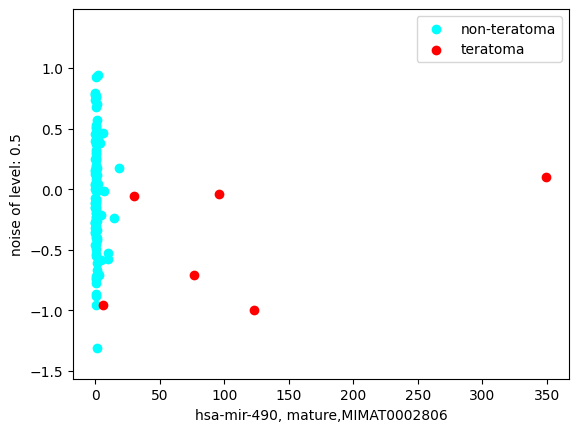

In [ ]:
plot_single_feature(mirna_normalized_isoforms_df, 'hsa-mir-490, mature,MIMAT0002806', samples_to_use = group1_samples + group2_samples, sample_label_dict= labels_teratoma, noise_level=0.5, label_color_dict = label_color_dict)
#

mutated vs ne mutated seminomos variantai

number of samples in KIT-mutated seminoma: 25
number of samples in KIT-Wildtype seminoma: 47
number of features expressed above 45 in KIT-mutated seminoma: 219
number of features expressed above 45 in KIT-Wildtype seminoma: 251
number of features in kept across both groups: 252


<ipython-input-8-f11d24ba1231>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


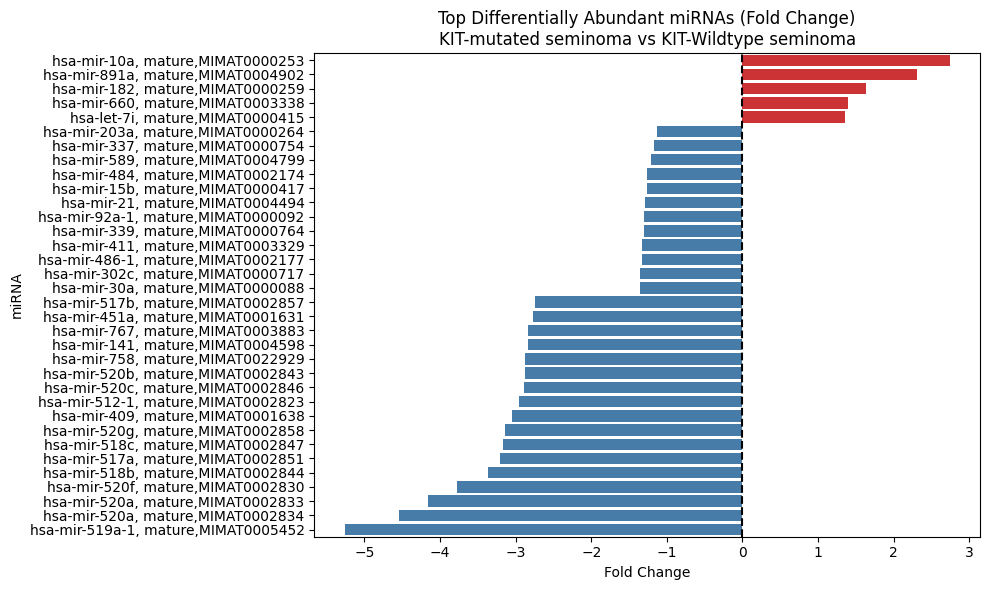

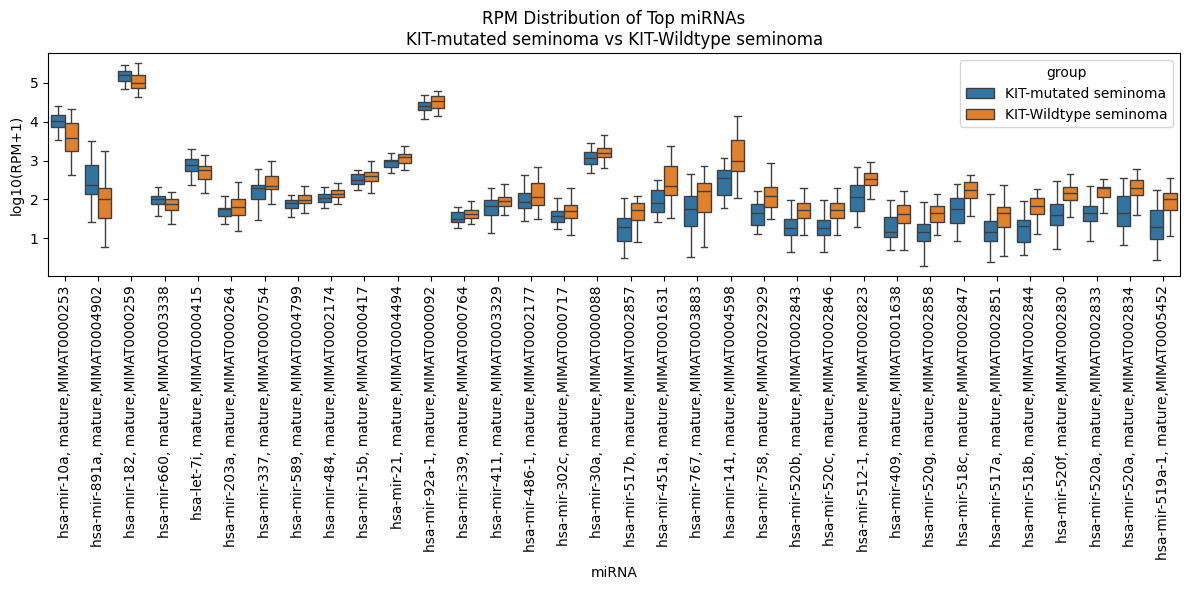

In [35]:
labels_seminoma_mutated_non_mutated = diagnoses.to_dict()
for sample in labels_seminoma_mutated_non_mutated.keys():
  if labels_seminoma_mutated_non_mutated[sample] == "seminoma" and  mdata_2['KIT'][sample] == 1:
    labels_seminoma_mutated_non_mutated[sample] = 'KIT-mutated seminoma'
  elif labels_seminoma_mutated_non_mutated[sample] == "seminoma" and  mdata_2['KIT'][sample] == 0:
    labels_seminoma_mutated_non_mutated[sample] = 'KIT-Wildtype seminoma'
  else:
    labels_seminoma_mutated_non_mutated[sample] = 'non-seminoma (unused)'

label_sample_dict = invert_label_dict(labels_seminoma_mutated_non_mutated, original_keys = 'samples')

group1_samples = prepare_sample_list(["KIT-mutated seminoma"], label_sample_dict=label_sample_dict)
group2_samples = prepare_sample_list(["KIT-Wildtype seminoma"], label_sample_dict=label_sample_dict)
group_names=["KIT-mutated seminoma", "KIT-Wildtype seminoma"]
results_mutated_non_mutated = plot_differential_miRNAs(df_to_use, group1_samples, group2_samples, group_names=group_names, label_dict = labels_seminoma_mutated_non_mutated)

In [36]:
results_mutated_non_mutated = reformat_results(results_mutated_non_mutated, 'KIT-mutated seminoma vs KIT-wildtype seminoma')
experiment_labels_df['KIT-mutated seminoma vs KIT-wildtype seminoma'] = labels_seminoma_mutated_non_mutated
experiment_results_df = pd.concat([experiment_results_df, results_mutated_non_mutated], axis=1)

In [39]:
experiment_results_df

,seminoma vs non-seminoma Fold Change,seminoma vs non-seminoma pval,seminoma vs non-seminoma fdr,seminoma vs non-seminoma significant,embryonal vs seminoma Fold Change,embryonal vs seminoma pval,embryonal vs seminoma fdr,embryonal vs seminoma significant,embryonal vs non_embryonal_non_seminoma Fold Change,embryonal vs non_embryonal_non_seminoma pval,embryonal vs non_embryonal_non_seminoma fdr,embryonal vs non_embryonal_non_seminoma significant,teratoma vs non-teratoma Fold Change,teratoma vs non-teratoma pval,teratoma vs non-teratoma fdr,teratoma vs non-teratoma significant,KIT-mutated seminoma vs KIT-wildtype seminoma Fold Change,KIT-mutated seminoma vs KIT-wildtype seminoma pval,KIT-mutated seminoma vs KIT-wildtype seminoma fdr,KIT-mutated seminoma vs KIT-wildtype seminoma significant
"hsa-let-7a-1, mature,MIMAT0000062",1.016323,0.147996,0.176211,False,1.251202,0.031470,0.053393,False,1.179961,0.328466,0.386562,False,1.236411,0.340722,0.413295,False,1.026332,0.476595,0.628805,False
"hsa-let-7a-1, mature,MIMAT0004481",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7a-2, mature,MIMAT0010195",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7b, mature,MIMAT0000063",-1.195322,0.869566,0.880203,False,1.235743,0.121741,0.166361,False,1.540435,0.113442,0.149813,False,1.002020,0.667536,0.712038,False,-1.045733,0.861233,0.915741,False
"hsa-let-7b, mature,MIMAT0004482",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"hsa-mir-98, mature,MIMAT0022842",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99a, mature,MIMAT0000097",2.974743,0.000019,0.000039,True,1.434068,0.107384,0.148930,False,-4.549685,0.004814,0.010787,True,8.568082,0.030821,0.073446,False,1.056682,0.886261,0.930574,False
"hsa-mir-99a, mature,MIMAT0004511",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99b, mature,MIMAT0000689",1.416475,0.000016,0.000034,True,-1.254802,0.006615,0.013408,True,-3.283565,0.000003,0.000097,True,2.410958,0.013427,0.038559,True,-1.357864,0.001741,0.007707,True


In [38]:
experiment_labels_df

,seminoma vs non-seminoma,embryonal vs seminoma,embryonal vs non_embryonal_non_seminoma,teratoma vs non-teratoma,KIT-mutated seminoma vs KIT-wildtype seminoma
TCGA-2G-AAEW-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
TCGA-2G-AAEX-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
TCGA-2G-AAF1-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-2G-AAF4-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
TCGA-2G-AAF6-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
...,...,...,...,...,...
TCGA-ZM-AA0D-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-ZM-AA0E-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-ZM-AA0F-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-ZM-AA0H-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma


Išsaugom grupių suskaidymus ir rezultatus:

In [40]:
#save the results and labels
experiment_labels_df.to_csv('TCGA_DE_experiment_suspected_labels.csv', sep = ';')
experiment_results_df.to_csv('TCGA_DE_reproduction_attempt_experiment_results.csv', sep = ';')

In [41]:
#check if the saved files can be read properly
results = pd.read_csv('TCGA_DE_reproduction_attempt_experiment_results.csv', sep = ';', index_col = 0)
labels = pd.read_csv('TCGA_DE_experiment_suspected_labels.csv', sep = ';', index_col = 0)

In [42]:
results

,seminoma vs non-seminoma Fold Change,seminoma vs non-seminoma pval,seminoma vs non-seminoma fdr,seminoma vs non-seminoma significant,embryonal vs seminoma Fold Change,embryonal vs seminoma pval,embryonal vs seminoma fdr,embryonal vs seminoma significant,embryonal vs non_embryonal_non_seminoma Fold Change,embryonal vs non_embryonal_non_seminoma pval,embryonal vs non_embryonal_non_seminoma fdr,embryonal vs non_embryonal_non_seminoma significant,teratoma vs non-teratoma Fold Change,teratoma vs non-teratoma pval,teratoma vs non-teratoma fdr,teratoma vs non-teratoma significant,KIT-mutated seminoma vs KIT-wildtype seminoma Fold Change,KIT-mutated seminoma vs KIT-wildtype seminoma pval,KIT-mutated seminoma vs KIT-wildtype seminoma fdr,KIT-mutated seminoma vs KIT-wildtype seminoma significant
"hsa-let-7a-1, mature,MIMAT0000062",1.016323,0.147996,0.176211,False,1.251202,0.031470,0.053393,False,1.179961,0.328466,0.386562,False,1.236411,0.340722,0.413295,False,1.026332,0.476595,0.628805,False
"hsa-let-7a-1, mature,MIMAT0004481",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7a-2, mature,MIMAT0010195",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-let-7b, mature,MIMAT0000063",-1.195322,0.869566,0.880203,False,1.235743,0.121741,0.166361,False,1.540435,0.113442,0.149813,False,1.002020,0.667536,0.712038,False,-1.045733,0.861233,0.915741,False
"hsa-let-7b, mature,MIMAT0004482",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"hsa-mir-98, mature,MIMAT0022842",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99a, mature,MIMAT0000097",2.974743,0.000019,0.000039,True,1.434068,0.107384,0.148930,False,-4.549685,0.004814,0.010787,True,8.568082,0.030821,0.073446,False,1.056682,0.886261,0.930574,False
"hsa-mir-99a, mature,MIMAT0004511",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"hsa-mir-99b, mature,MIMAT0000689",1.416475,0.000016,0.000034,True,-1.254802,0.006615,0.013408,True,-3.283565,0.000003,0.000097,True,2.410958,0.013427,0.038559,True,-1.357864,0.001741,0.007707,True


In [43]:
labels

,seminoma vs non-seminoma,embryonal vs seminoma,embryonal vs non_embryonal_non_seminoma,teratoma vs non-teratoma,KIT-mutated seminoma vs KIT-wildtype seminoma
TCGA-2G-AAEW-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
TCGA-2G-AAEX-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
TCGA-2G-AAF1-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-2G-AAF4-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
TCGA-2G-AAF6-01,seminoma,seminoma,unused,non-teratoma,KIT-Wildtype seminoma
...,...,...,...,...,...
TCGA-ZM-AA0D-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-ZM-AA0E-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-ZM-AA0F-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma
TCGA-ZM-AA0H-01,seminoma,seminoma,unused,non-teratoma,KIT-mutated seminoma


In [ ]:
mdata_2.columns

Index(['SCNA_k5', 'miRNA_k3', 'methylation_k5', 'mRNA_k4', 'RPPA_k4',
       'PARADIGM_k3', 'age_at_diagnosis', 'race', 'ethnicity',
       'two-class updated 20160629', 'multiclass updated 20160629',
       'Seminoma % ', 'Embryonal carcinoma %', 'Yolk sac tumor %', 'Mature %',
       'Immature %', 'Choriocarcinoma %', 'history_of_undescended_testis',
       'Family_History_Testicular_Cancer', 'Family_History_ Any_Cancer',
       'New_Primary_tumor', 'purity', 'ploidy', 'Genome doublings',
       'Cancer DNA fraction', 'Subclonal genome fraction', 'AverageCpH',
       'AverageCpG at CGI', 'AverageCpG at nonCGI', 'CpH Methylation Mode',
       'leukocyte infiltration', 'KIT', 'KRAS', 'NRAS', 'PIK3CA', 'q2020cov',
       '#Silent', '#Nonsilent', '#Total', 'Silent (per Mb)',
       'Nonsilent (Per Mb)', 'Total (Per Mb)', 'C:G>A:T %', 'C:G>G:C %',
       'C:G>T:A %', 'T:A>A:T %', 'T:A>C:G %', 'T:A>G:C %', 'INDEL %', 'DNM %',
       'KRAS_mut', 'KRAS_mut_multiplicity', 'KRAS_copies', 'KRAS

In [ ]:
len(label_sample_dict['non-teratoma'])

107

In [ ]:
diagnoses.value_counts()

,count
multiclass updated 20160629,
seminoma,72
embryonal,18
mature teratoma dominant,10
embryonal dominant,9
non-seminoma- mixed (no dominant component),9
yolk sac dominant,8
yolk sac,5
mature teratoma,3
immature teratoma dominant,3


Čia etikečių tvarkymas (tiesiogiai nnesusiję su DE)

In [ ]:
mdata_1.to_csv('sample_data_1.csv', sep = ';')

In [ ]:
mdata_2.loc['TCGA-2G-AAGY-01']['multiclass updated 20160629']

'mature teratoma dominant'

In [ ]:
#Drop row 0 from mdata. make column names be the values in row 1:
mdata = mdata.drop(0)
mdata.columns = mdata.iloc[0]
mdata = mdata.drop(1)

In [ ]:
mdata.set_index('sample', inplace=True)

In [ ]:
mdata.to_csv('sample_data_2.csv', sep = '|')

In [ ]:
sample_data = pd.read_csv(url, sep = '|', index_col = 0)

In [ ]:
sample_data.columns

Index(['SCNA_k5', 'miRNA_k3', 'methylation_k5', 'mRNA_k4', 'RPPA_k4',
       'PARADIGM_k3', 'age_at_diagnosis', 'race', 'ethnicity',
       'two-class updated 20160629', 'multiclass updated 20160629',
       'Seminoma % ', 'Embryonal carcinoma %', 'Yolk sac tumor %', 'Mature %',
       'Immature %', 'Choriocarcinoma %', 'history_of_undescended_testis',
       'Family_History_Testicular_Cancer', 'Family_History_ Any_Cancer',
       'New_Primary_tumor', 'purity', 'ploidy', 'Genome doublings',
       'Cancer DNA fraction', 'Subclonal genome fraction', 'AverageCpH',
       'AverageCpG at CGI', 'AverageCpG at nonCGI', 'CpH Methylation Mode',
       'leukocyte infiltration', 'KIT', 'KRAS', 'NRAS', 'PIK3CA', 'q2020cov',
       '#Silent', '#Nonsilent', '#Total', 'Silent (per Mb)',
       'Nonsilent (Per Mb)', 'Total (Per Mb)', 'C:G>A:T %', 'C:G>G:C %',
       'C:G>T:A %', 'T:A>A:T %', 'T:A>C:G %', 'T:A>G:C %', 'INDEL %', 'DNM %',
       'KRAS_mut', 'KRAS_mut_multiplicity', 'KRAS_copies', 'KRAS

In [ ]:
sample_data.loc['TCGA-2G-AAGX-01']['multiclass updated 20160629']

'mature teratoma dominant'

In [ ]:
sample_data['Yolk sac tumor %']

,Yolk sac tumor %
sample,
TCGA-2G-AAEW-01,NaN
TCGA-2G-AAEX-01,NaN
TCGA-2G-AAF1-01,NaN
TCGA-2G-AAF4-01,NaN
TCGA-2G-AAF6-01,NaN
...,...
TCGA-ZM-AA0D-01,NaN
TCGA-ZM-AA0E-01,NaN
TCGA-ZM-AA0F-01,NaN
